In [10]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

In [11]:
def data_transform():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform

In [12]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img.cpu().numpy().squeeze().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

In [13]:
class SVHNDataset(data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotation = annotation
        self.transforms = transforms
        self.ids = os.listdir(root)
        self.classes = [i for i in range(0,11)]
        self.device = device
    def __getitem__(self, index):
        with open(self.annotation, 'r') as anno:
            json_file = json.load(anno)
            
        obj_name = json_file[index]['filename']
        img_id = Image.open(os.path.join(self.root,obj_name))
            
        obj_boxes = json_file[index]['boxes']
        
        num_obj = len(obj_boxes)
        boxes = []
        labels = []
        for i in range(num_obj):
            xmin =  obj_boxes[i]['left']
            ymin =  obj_boxes[i]['top']
            xmax =  xmin + obj_boxes[i]['width']
            ymax =  ymin + obj_boxes[i]['height']
            label = obj_boxes[i]['label']
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(label)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.LongTensor(labels)
        index = torch.Tensor([index])
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = index
        my_annotation["iscrowd"] = iscrowd
        my_annotation["area"] = area
        
        if self.transforms is not None:
            img = self.transforms()(img_id)
        
        return img, my_annotation
    
    def __len__(self):
        return len(self.ids)
    

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
#Visualize 10 training samples
def visualize_samples():
    fig = plt.figure(figsize=(15,10))
    plt.title("Training Samples")
    for id,(img,anno) in enumerate(dataloader): 
        if id==9:
            break
        ax = fig.add_subplot(3,3,id+1)
        for label, box in zip(anno[0]["labels"], anno[0]["boxes"]):
            rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,ec="red",lw=3)
            plt.text(box[0],box[1]-3,int(label.numpy()),color="red",fontsize=15, fontweight='bold')
            ax.add_patch(rect)
        img = imshow(img[0])
        plt.imshow(img)
    plt.show()
#visualize_samples()

In [16]:
def instance_segmentation_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

#print(model)

In [17]:

def train(model,dataloader):
    EPOCHS = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    #error = nn.CrossEntropyLoss()
    loss_list = []
    print("Start training...")
    for epoch in range(EPOCHS):
        model.train()
        for imgs,anno in tqdm(dataloader):
        
            imgs = list(image.to(device) for image in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in anno]
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            loss_list.append(losses)
        print(f'Epoch: [{epoch}/{EPOCHS}], Loss: {losses}')
        torch.save(model.state_dict(), "model/model.pth")
    print("Training Completed!")
    
    return model, loss_list

In [50]:
def predict(model, img):
    model.eval()
    x,y = img.size
    img = data_transform()(img)
    imgs = Variable(img).view(-1,3,y,x)
    #print(img.shape)
    outputs = model(imgs)
    return outputs

In [45]:
if __name__ == "__main__":
    device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
    ANNOTATION_DIR = {
    "train": "annotation/train.json",
    "val": "annotation/val.json"
    }

    DATA_DIR = {
        "train": "data/train",
        "val": "data/val"
    }
    """
    TRAIN_DATA = 0
    dataset = SVHNDataset(DATA_DIR["train"],ANNOTATION_DIR["train"],transforms=data_transform)
    dataloader = data.DataLoader(dataset,batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers = 4)
    CLASSES = dataset.classes
    NUM_CLASSES = len(CLASSES)
    TRAINING_SAMPLES =len(dataset)
    model = instance_segmentation_model(NUM_CLASSES)
    model = model.to(device)
    if TRAIN_DATA:
        model, loss_list = train(model,dataloader)
    """
    model = instance_segmentation_model(NUM_CLASSES)
    model = model.to(device)
    model.load_state_dict(torch.load("model/model.pth", map_location=device))
    print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [87]:
img = Image.open("data/2.jpg")
prediction = predict(model,img)
print(prediction)

[{'boxes': tensor([[118.1740,  52.6161, 144.4432,  95.9833],
        [196.0254,   5.5980, 256.8625, 179.6735],
        [141.9238,  41.2719, 179.7419, 110.9010],
        [106.9371,  40.0586, 143.7901, 100.8216],
        [142.9583,  47.9147, 168.3447,  99.2366],
        [143.4342,  51.8910, 165.0494,  99.9277],
        [200.7610, 116.4449, 253.4677, 179.4796],
        [198.5923, 106.9669, 270.9283, 290.7010],
        [281.6624, 154.1439, 289.3937, 183.7199],
        [223.7948, 124.4714, 243.4752, 180.0725],
        [276.7799, 152.9799, 297.9324, 190.4427],
        [152.0626,  44.2494, 171.6327, 107.4594],
        [317.7919, 156.5317, 347.7114, 276.5455],
        [141.8544,  50.3007, 166.5592,  97.6618],
        [136.2523,  40.8632, 179.7186, 108.5612],
        [255.6586,  70.9722, 368.6107, 292.2277],
        [202.2450, 118.6791, 231.5574, 180.4810],
        [284.9519, 143.3716, 305.8858, 195.3224],
        [302.8813, 143.7933, 323.0811, 189.6528],
        [275.2579, 150.0614, 303.2160, 

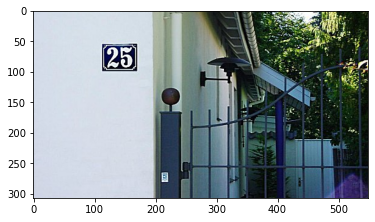

In [88]:
plt.imshow(img)
plt.show()

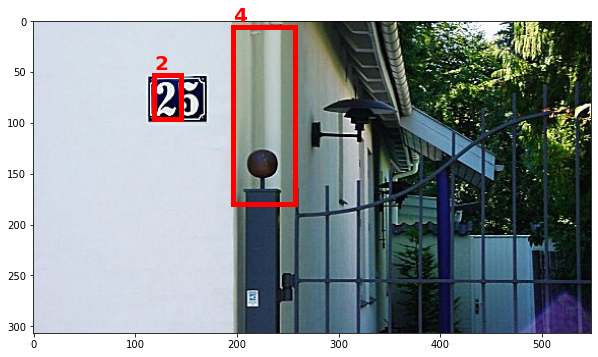

In [90]:
fig = plt.figure(figsize=(10,10))
bboxes = prediction[0]["boxes"][:2]
labels = prediction[0]["labels"][:2]
plt.imshow(img)
ax = plt.gca()
for box, label in zip(bboxes,labels):
    x,y,x2,y2 = box
    rect = patches.Rectangle((x,y),x2-x,y2-y,color="red",lw=5,fill=False)
    plt.text(x,y-5,label.numpy(),color="red",fontsize=20, fontweight='bold')
    ax.add_patch(rect)
plt.show()

In [61]:
print(bboxes)

tensor([[243.9964, 202.7525, 278.5701, 289.2940],
        [319.3501, 202.5857, 350.1984, 278.8241],
        [296.3873, 203.9979, 324.9501, 287.6281],
        [271.1288, 201.5258, 298.9976, 284.7569]], grad_fn=<SliceBackward>)
